# Wstęp do Sztucznej Inteligencji
## Ewolucyjne podejście do optymalizacji klasyfikatora opartego na zestawie reguł rozmytych

Celem laboratorium jest implementacja klasyfikatora opartego na regułach rozmytych. Postać reguł rozmytych może być optymalizowana za pomocą algorytmu ewolucyjnego.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

Zaczniemy od prostego problemu klasyfikacyjnego irysów. Dane te opisują 150 przykładów kwiatów, każdy należący do jednego z trzech gatunków. Mamy zatem do czynienia z problemem klasyfikacyjnym z trzema klasami.

Każdy przykład opisany jest czterema atrybutami (cechami). Na ich podstawie nasz klasyfikator ma podejmować decyzję, do której klasy przypisać dany przykład. 

Proces uczenia takiego modelu to przykład uczenia z nauczycielem (ang. supervised learning).


In [4]:
from sklearn.preprocessing import LabelEncoder

data_path = 'iris.csv'
data = pd.read_csv(data_path, header=None, delimiter=r"\s+")
data.columns = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
print(data.head())

# encode as np matrix
X = features_matrix = data.iloc[:, 0:4].to_numpy()
print(X.shape)
Y = data['Species'].to_numpy()
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y)



   SepalLength  SepalWidth  PetalLength  PetalWidth      Species
0          5.1         3.5          1.4         0.2  Iris-setosa
1          4.9         3.0          1.4         0.2  Iris-setosa
2          4.7         3.2          1.3         0.2  Iris-setosa
3          4.6         3.1          1.5         0.2  Iris-setosa
4          5.0         3.6          1.4         0.2  Iris-setosa
(150, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Po wczytaniu danych, warto się im przyjrzeć i ocenić trudność problemu.

Które atrybuty wydają się szczególnie przydatne w tym problemie? Zwróć uwagę, że przy takiej wizualizacji danych nie widzimy dokładnie jak dobrze te dane są odseparowane w oryginalnej przestrzeni (w tym przypadku 4D).

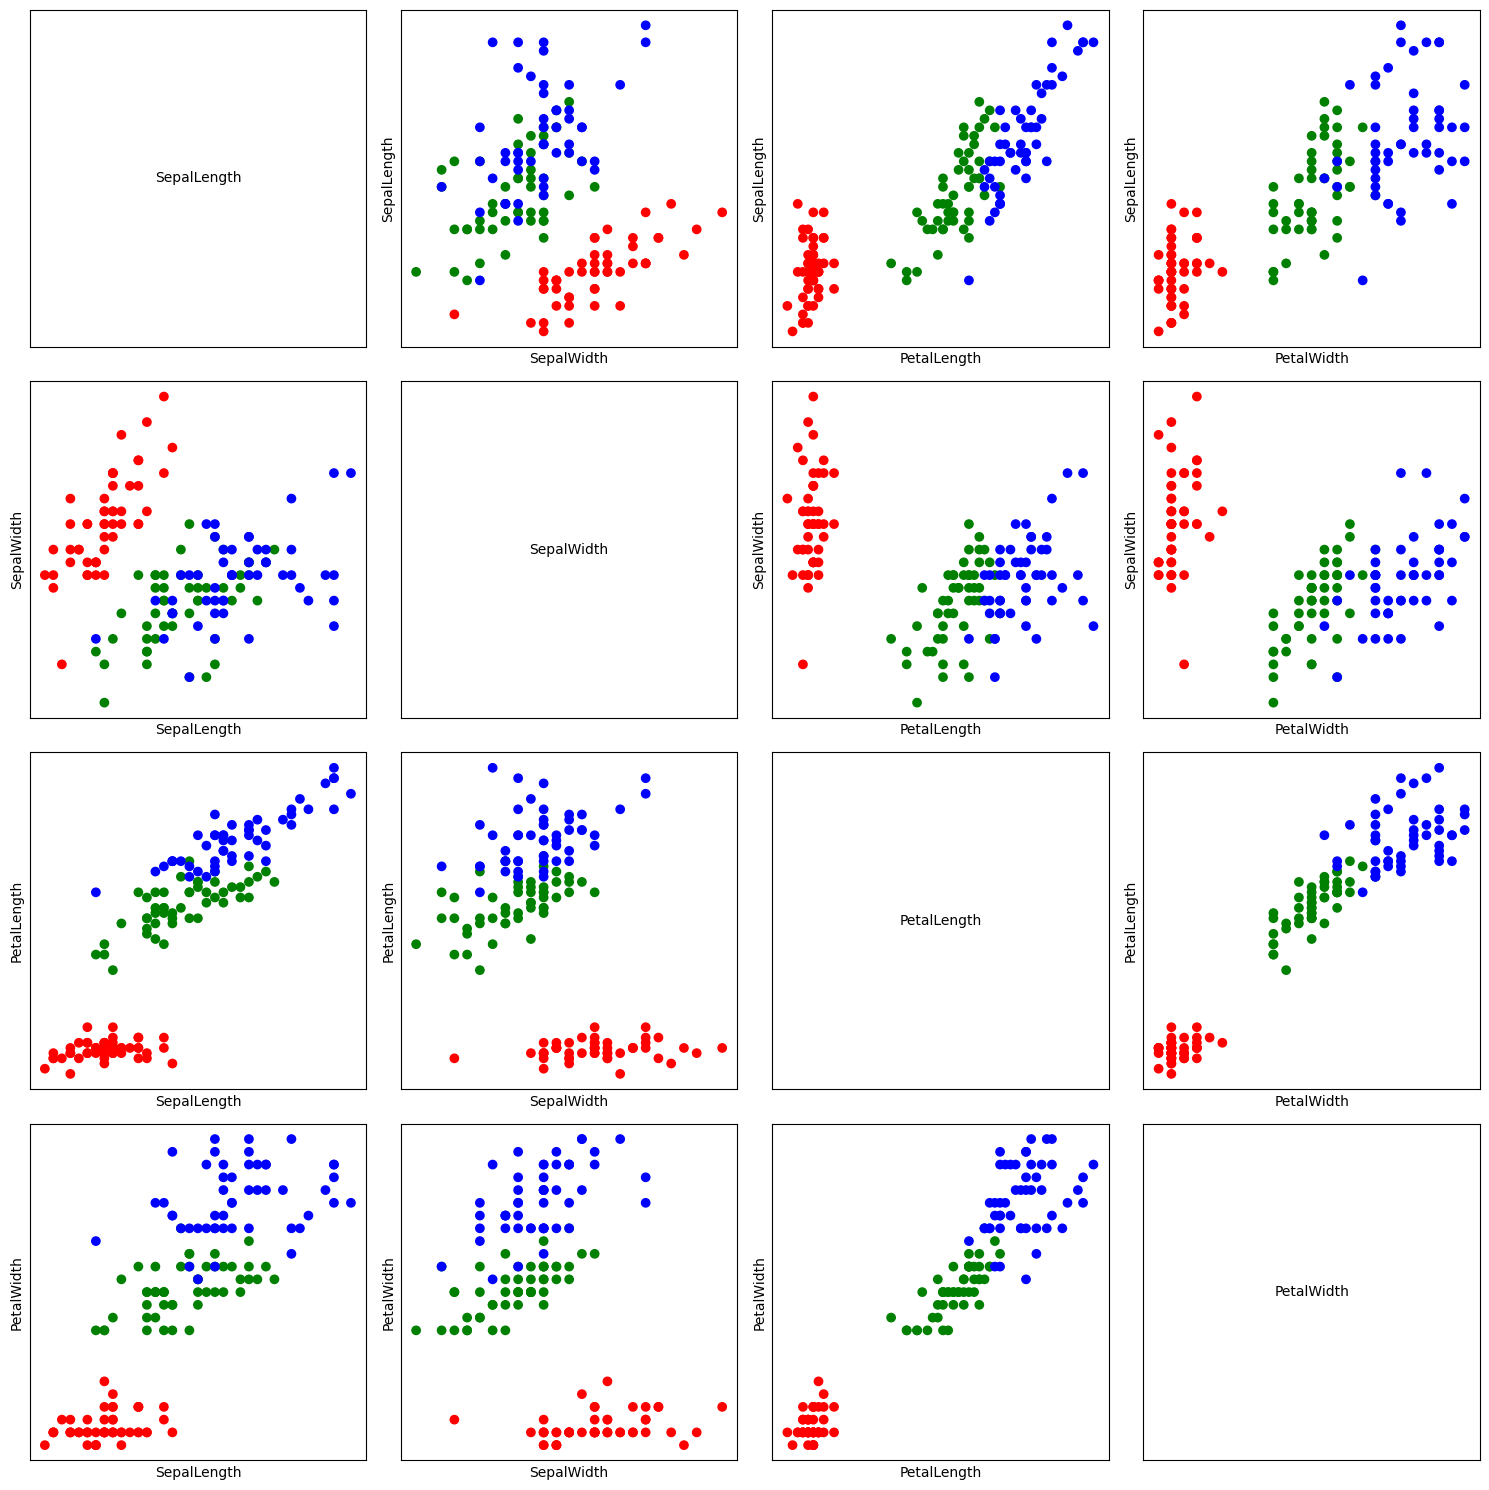

In [5]:
colors = ['red', 'green', 'blue']  
data['Species'] = Y
# Rysowanie wykresów dla każdej pary cech
fig, axs = plt.subplots(4, 4, figsize=(15, 15))  # Ustawienie siatki wykresów
for i in range(4):
    for j in range(4):
        if i != j:
            axs[i, j].scatter(data.iloc[:, j], data.iloc[:, i], c=data['Species'].map(lambda x: colors[x]))
            axs[i, j].set_xlabel(data.columns[j])
            axs[i, j].set_ylabel(data.columns[i])
        else:
            axs[i, j].text(0.5, 0.5, data.columns[i], horizontalalignment='center', verticalalignment='center')
            axs[i, j].set_xlabel('')
            axs[i, j].set_ylabel('')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.tight_layout()
plt.show()

Dane dzielimy na dane trenujące i testowe. Klasyfikator powinien być przetestowany na danych, z którymi nie miał styczności w czasie procesu uczenia.

In [6]:
test_perc = 0.3 
indxs = np.random.permutation(X.shape[0])
ii = int(test_perc*X.shape[0])
Xtest = X[indxs[:ii]]
Ytest = Y[indxs[:ii]]
X = X[indxs[ii:]]
Y = Y[indxs[ii:]]
print(X.shape, Xtest.shape)

(105, 4) (45, 4)


Do zdefiniowania funkcji przynależności potrzebne będą zakresy wartości zmiennych.

In [7]:
mins = X.min(axis=0)
maxs = X.max(axis=0)
print(mins)
print(maxs)

[4.4 2.  1.2 0.1]
[7.9 4.2 6.9 2.5]


Nasz przykładowy klasyfikator rozmyty będzie korzystał z trójkątnych funkcji przynależności.

In [8]:
def trfun(x, a, b, c):
    return 0 if (x < a or x > c) else ((x-a)/(b-a) if (x >= a and x <= b) else (c-x)/(c-b))

Klasyfikator rozmyty podejmuje decyzję na podstawie zbioru reguł rozmytych w postaci:

JEŚLI x1 jest MAŁE i x2 jest ŚREDNIE i x4 jest DUŻE wtedy KLASA_1

Zwróć uwagę, że w powyższym przykładzie nie jest wykorzystane x3.

Obiekt poniższej klasy FuzzyClassifier przechowuje dla każdego wymiaru (x1 do x4 w przypadku irysów) zadaną liczbę wartości lingwistycznych reprezentowanych przez trójkątne funkcje prznależności definiowane przez trzy parametry. Dla każdego wymiaru może to być różna liczba (parametr fnums).

Reguły rozmyte zakodowane są w polu rules. Każda reguła to lista, której kolejne wartości wskazują, do której funkcji przynależności odnosi się ta reguła w danym wymiarze, a ostatni element to indeks klasy z wniosku reguły. Jeśli występuje wartość -1, to ten atrybut nie jest brany pod uwagę przez daną regułę.

Przykład:

[-1, -1, 0, 2, 2]

Reguła ta odnosi się do x3 (pierwsza funckcja przynależności) oraz x4 (trzecia funkcja przynależności). We wniosku wskazuje klasę o indeksie 2 (trzecią).

Podczas klasyfikacji sprawdzane są wartości odpowiednich funkcji przynależności dla konkretnych wartości x1 do x4. Stopień spełnialności części warunkowej danej reguły określany jest za pomocą odpowiedniej t-normy (minimum w tym przykładzie). Jeśli więcej niż jedna reguła ma we wniosku daną klasę, wartości stopni spełnialności warunków tych reguł agregowane są za pomocą odpowiedniej s-normy (maksimum w tym przykładzie). Ostatecznie wybierana jest klasa, na którą wskazuje maksymalna wartość.

In [9]:
class FuzzyClassifier:
    def __init__(self, nclass, dim, fnums, mins, maxs):
        self.nclass = nclass #number of classes
        self.dim = dim #number of input features
        self.fnums = fnums #list: number of linguistic values for each feature
        self.mins = mins #minimum values of features
        self.maxs = maxs #maximum values of features
        self.funs = None #parametry funkcji przynależności (tu: trójkątnej)
        self.rules = None #reguły
        self.tnorm_condition = None #t-norma używana do oceny części warunkowej reguły
        self.snorm_aggregation = None #s-norma używana do agregacji

    def init_triangular_funs(self):
        """
        Dla każdego wymiaru generuje zadaną liczbę równomiernie rozłożonych trójkątnych funkcji przynależności
        """
        self.funs = []
        for i in range(self.dim):
            step = (self.maxs[i] - self.mins[i])/(self.fnums[i] - 1)
            tmp = []
            for j in range(self.fnums[i]):
                center = self.mins[i]+j*step
                tmp.append((center - step, center, center + step))
            self.funs.append(tmp)
    
    def gen_random_rules(self, n):
        """
        Generuje zadaną liczbę losowych reguł
        """
        return [[np.random.randint(-1, num) for num in self.fnums] + [np.random.randint(0, nclass)] for i in range(n)]
    
    def classify(self, x):
        """
        Klasyfikuje pojedynczy przykład x
        """
        votes = [[] for i in range(self.nclass)]
        for r in self.rules:
            conditions = []
            for i, findx in enumerate(r[:-1]):
                if findx == -1:
                    continue
                a, b, c = self.funs[i][findx]
                conditions.append(trfun(x[i], a, b, c))
            condition_sat_level = self.tnorm_condition(conditions) if len(conditions) > 0 else 0
            votes[r[-1]].append(condition_sat_level)
        votes = [self.snorm_aggregation(v) if len(v) > 0 else 0 for v in votes]
        return np.argmax(votes)
    
    def classify_all(self, X):
        """
        Klasyfikuje wszystkie przykłady - wiersze macierzy X
        """
        return np.array([self.classify(x) for x in X])
    
    def test(self, X, Y):
        """
        Klasyfikuje przykłady z X i porównuje z prawidłowymi etykietami klas z Y

        Zwraca accuracy - odsetek poprawnych klasyfikacji
        """
        return (Y == self.classify_all(X)).sum()/X.shape[0]
                

Ustawienia dla problemu irysów:

In [10]:
nclass = 3 #liczba klas
dim = 4 #liczba atrybutów
fnums = [3, 3, 3, 3] #liczba funcji przynależności (wartości lingwistycznych) dla każdego atrybutu

Tworzymy obiekt FuzzyClassifier i wizualizujemy funkcje przynależności.

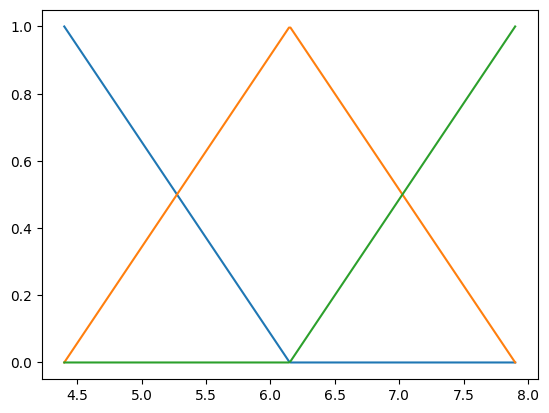

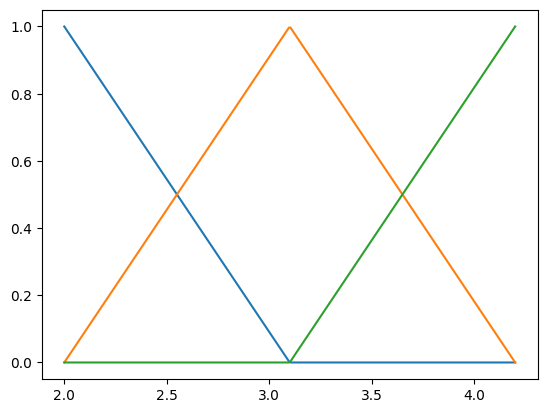

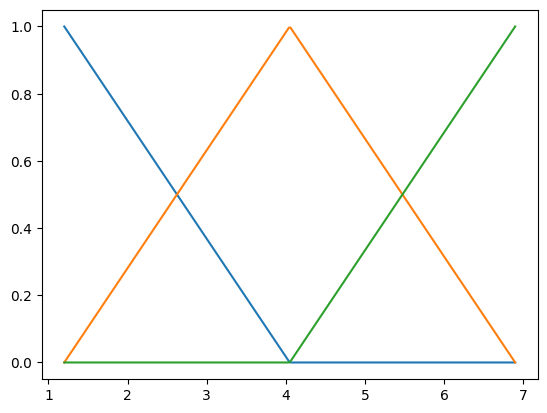

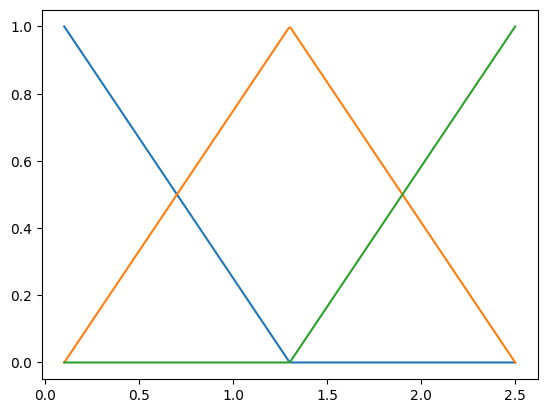

In [11]:
fc = FuzzyClassifier(nclass, dim, fnums, mins, maxs)
fc.init_triangular_funs()
for i, f in enumerate(fc.funs):
    xx = np.linspace(mins[i], maxs[i], 300)
    plt.figure()
    for ff in f:
        a, b, c = ff
        mfun = np.vectorize(lambda x: trfun(x, a, b, c), otypes=[float])
        yy = mfun(xx)
        plt.plot(xx, yy)
plt.show()
    

Generujemy przykładowe reguły

In [12]:
r = fc.gen_random_rules(3)
print(r)

# Przy ustawieniach fnums = [5, 5, 5, 5] następujące reguły dają całkiem nieźle działajacy klasyfikator
# fc.rules = [[-1, -1, -1, 4, 2], [-1, -1, -1, 3, 2], [-1, -1, -1, 2, 1], [-1, -1, 1, -1, 0]]

[[2, 0, 1, 0, 1], [-1, 0, 2, -1, 0], [1, 0, -1, 0, 2]]


Ustawiamy t-normę i s-normę

In [13]:
fc.tnorm_condition = lambda x: min(x)
fc.snorm_aggregation = lambda x: max(x)

Test klasyfikatora

In [14]:
fc.rules = r
acc = fc.test(X, Y)
print(acc)
Z = fc.classify_all(X)
print(Z)

0.29523809523809524
[0 2 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0]


Mutacja będzie polegać na zmianie aktualnej wartości na losową, dozwoloną na danej pozycji (z pewnym prawdopodobieństwem).

In [15]:
def mutate(rule_set, prob_mut):
    """
    Mutacja poprzez zmianę na losową wartość dopuszczalną na danej pozycji.
    Klasa z wniosku reguły również może się zmienić.
    """
    for r in rule_set:
        for i in range(fc.dim):
            if np.random.rand() < prob_mut:
                r[i] = np.random.randint(-1, fc.fnums[i])
        if np.random.rand() < prob_mut:
            r[-1] = np.random.randint(0, fc.nclass)

Generujemy losową początkową populację.

Każdy osobnik koduje cały zestaw reguł rozmytych.

Wszytkie osobniki korzystać będą z tego samego zestawu funkcji przynależności.

In [16]:
nrules = 5
pop_size = 10
pop = [fc.gen_random_rules(nrules) for i in range(pop_size)]
print(pop)

[[[-1, 1, 2, 1, 2], [0, 1, -1, 0, 2], [2, 1, 2, -1, 1], [1, -1, -1, 0, 1], [-1, 1, -1, 1, 0]], [[-1, 0, 0, 0, 2], [0, -1, -1, 2, 0], [1, -1, 2, -1, 1], [-1, 2, 0, -1, 2], [-1, 1, 1, 1, 2]], [[2, 2, -1, 0, 0], [0, -1, -1, 1, 1], [0, 2, -1, 0, 2], [1, -1, 0, -1, 0], [-1, -1, 0, 0, 2]], [[-1, 2, -1, 1, 1], [1, 0, 1, 0, 0], [-1, 1, 2, -1, 1], [0, 1, -1, 1, 2], [1, 2, 0, 2, 1]], [[2, -1, -1, 1, 1], [0, -1, 2, 0, 0], [0, -1, -1, 2, 0], [2, -1, 2, 0, 1], [2, 2, 2, 2, 1]], [[-1, -1, -1, 2, 2], [0, 2, -1, 2, 2], [2, 1, 1, 0, 1], [1, -1, 1, 0, 0], [0, 2, 0, 2, 0]], [[2, -1, 1, 0, 1], [0, 0, -1, 2, 2], [0, -1, 1, 1, 2], [-1, -1, -1, -1, 2], [2, -1, -1, 1, 1]], [[0, 1, 2, 2, 2], [-1, -1, 2, -1, 0], [0, -1, 2, 2, 0], [0, 2, 1, 0, 1], [0, 1, 1, -1, 1]], [[0, -1, 0, -1, 2], [0, 2, 2, -1, 1], [-1, -1, 1, -1, 0], [0, 0, 1, 1, 1], [0, 1, 1, -1, 2]], [[-1, -1, -1, 0, 1], [2, 2, -1, 0, 0], [-1, 1, 2, 2, 1], [0, -1, -1, 0, 2], [0, 1, 0, -1, 2]]]


Ewaluacja osobników i zapamiętanie najlepszego.

Funkcją przystosowania jest odsetek poprawnych klasyfikacji na zbiorze trenującym.

In [17]:
evals = []
for rule_set in pop:
    fc.rules = rule_set
    evals.append(fc.test(X, Y))
print(evals)

srt = sorted(zip(evals, pop))[::-1]
best_rs = copy.deepcopy(srt[0][1])
best_eval = srt[0][0]
print('best ', best_eval)
print(best_rs)

[0.01904761904761905, 0.12380952380952381, 0.2571428571428571, 0.20952380952380953, 0.42857142857142855, 0.6285714285714286, 0.21904761904761905, 0.2, 0.0, 0.23809523809523808]
best  0.6285714285714286
[[-1, -1, -1, 2, 2], [0, 2, -1, 2, 2], [2, 1, 1, 0, 1], [1, -1, 1, 0, 0], [0, 2, 0, 2, 0]]


Przykładowy algorytm ewolucyjny jest bardzo prosty. 

Jego jedyny operator to mutacja.

Każdy z osobników z aktualnej populacji jest kopiowany a następnie mutowany.

Stara i nowa (zmutowana) populacja są łączone.

Pozostawiamy pop_size najlepszych osobników (nacisk selekcyjny).

Przetestujmy jego działanie.

In [18]:
iters = 100
prob_mut = 0.1

for i in range(iters):
    # kopiowanie każdego osobnika
    pop2 = [copy.deepcopy(rs) for rs in pop] 
    # mutacja
    for rule_set in pop2:
        mutate(rule_set, prob_mut)
    # ocena nowych rozwiązań
    evals2 = []
    for rule_set in pop2:
        fc.rules = rule_set
        evals2.append(fc.test(X, Y))
    # łączenie obu populacji
    pop = pop + pop2
    evals = evals + evals2
    # pozostawienie stałej liczby najlepszych osobników
    srt = sorted(zip(evals, pop))[::-1]
    pop = [s[1] for s in srt][:pop_size]
    evals = [s[0] for s in srt][:pop_size]
    # zapamiętanie najlepszego rozwiązania
    if evals[0] > best_eval:
        print('better found', evals[0], 'in',i+1)
        best_eval = evals[0]
        best_rs = copy.deepcopy(pop[0])
print('end')


better found 0.6571428571428571 in 3
better found 0.7142857142857143 in 5
better found 0.8095238095238095 in 9
better found 0.8571428571428571 in 10
better found 0.8952380952380953 in 18
better found 0.9047619047619048 in 21
better found 0.9142857142857143 in 71
better found 0.9238095238095239 in 76
better found 0.9333333333333333 in 96
end


Spradzamy odpowiedzi najlepszego osobnika na zbiorze trenującym:

In [19]:
print(best_eval)
print(best_rs)
fc.rules = best_rs
z = fc.classify_all(X)
print(z)
print(Y)
print(fc.test(X, Y))

0.9333333333333333
[[-1, -1, -1, 2, 2], [0, 1, 1, 0, 0], [1, 0, 1, 1, 1], [1, 2, 2, 2, 2], [2, 1, 1, 1, 1]]
[0 1 0 0 1 1 2 1 1 1 2 2 2 2 1 1 2 0 2 2 1 1 0 1 0 0 2 2 2 1 2 0 1 0 2 0 2
 0 2 2 1 0 2 1 2 1 2 2 1 0 0 0 2 2 0 1 0 0 1 2 0 0 1 0 0 2 2 1 2 2 1 0 2 0
 2 0 0 1 1 1 1 1 1 0 2 2 1 1 1 0 1 1 2 0 0 1 1 2 2 0 0 1 0 2 2]
[0 1 0 0 1 1 2 1 1 1 2 2 2 2 2 1 2 0 2 2 1 1 0 1 0 0 1 2 2 1 2 0 1 0 2 0 2
 0 2 2 1 0 2 2 2 1 2 2 1 0 0 0 1 2 0 1 0 0 1 1 0 0 1 0 0 2 2 1 2 2 1 0 2 0
 1 0 0 1 1 1 1 1 1 0 1 2 1 1 1 0 1 1 2 0 0 1 1 2 2 0 0 1 0 2 2]
0.9333333333333333


...oraz testowym.

In [20]:
# testing
ans = fc.classify_all(Xtest)
print(ans)
print(Ytest)
print(fc.test(Xtest, Ytest))

[1 0 2 2 0 2 0 0 0 0 0 1 1 2 0 1 1 0 1 1 1 2 2 2 2 0 0 2 0 0 2 0 1 1 2 2 2
 0 2 2 0 2 1 0 2]
[1 0 2 2 0 2 0 0 0 0 0 1 1 1 0 1 1 0 1 2 1 2 2 2 1 0 0 2 0 0 1 0 1 2 2 2 2
 0 2 2 0 2 2 0 2]
0.8666666666666667


Wykonaj przykładowe obliczenia dla różnych ustawień (liczba funckji przynależności, liczba reguł, wielkość populacji itd.)

### Zadanie (10 punktów)

In [21]:
nr_indeksu = 142706

In [22]:
print(r"""
Zaimplementuj własny algorytm ewolucyjny do optymalizacji klasyfikatora rozmytego. 

Przetestuj go na trudniejszym problemie klasyfikacyjnym diagnozy cukrzycy (baza pima - ostatnia kolumna zawiera etykietę klasy).

Ile minimalnie reguł jest potrzebnych?

Wnioski zaprezentuj na podstawie średniej z co najmniej 10 uruchomień.

W algorytmie dodaj możliwość ewolucji parametrów użytych funkcji przynależności 
(a więc nie są one wspólne dla wszytkich rozwiązań lecz podlegają optymalizacji).

Porównaj działanie swojego algorytmu z przykładowym algorytmem z zajęć.

Algorytm powinien mieć następujące funkcjonalności 
(zastosuj operator krzyżowania nawet jeśli nie występuje on w oryginalnym opisie algorytmu):
""")

algorytm = ['algorytm genetyczny', 'strategia ewolucyjna u+s', 'strategia ewolucyjna u,s', 'programowanie ewolucyjne']
selekcja = ['koło ruletki', 'turniejowa', 'rankingowa']
xover = ['jednopunktowe', 'dwupunktowe', 'jednostajne', 'uśrednianie ze współczynnikiem a']
mutacja = ['rozkład jednostajny', 'rozkład Gaussa']
memfun = ['klasa pi', 'trapezoidalna', 'dzwonowa', 'Gaussa']
tnorm = ['minimum', 'iloczyn']
snorm = ['maksimum', 'suma-iloczyn']

print('Algorytm: ', algorytm[nr_indeksu%len(algorytm)])
print('Rodzaj selekcji (jeśli dotyczy): ', selekcja[nr_indeksu%len(selekcja)])
print('Krzyżowanie: ', xover[nr_indeksu%len(xover)])
print('Mutacja wartości rzeczywistych (jeśli nie jest określona przez algorytm): ', mutacja[nr_indeksu%len(mutacja)])
print('Rodzaj funkcji przynależności: ', memfun[nr_indeksu%len(memfun)])
print('Rodzaj t-normy: ', tnorm[nr_indeksu%len(tnorm)])
print('Rodzaj s-normy: ', snorm[nr_indeksu%len(snorm)])

print(r"""
W razie wątpliwości - ustal szczegóły z prowadzącym zajęcia.
""")


Zaimplementuj własny algorytm ewolucyjny do optymalizacji klasyfikatora rozmytego. 

Przetestuj go na trudniejszym problemie klasyfikacyjnym diagnozy cukrzycy (baza pima - ostatnia kolumna zawiera etykietę klasy).

Ile minimalnie reguł jest potrzebnych?

Wnioski zaprezentuj na podstawie średniej z co najmniej 10 uruchomień.

W algorytmie dodaj możliwość ewolucji parametrów użytych funkcji przynależności 
(a więc nie są one wspólne dla wszytkich rozwiązań lecz podlegają optymalizacji).

Porównaj działanie swojego algorytmu z przykładowym algorytmem z zajęć.

Algorytm powinien mieć następujące funkcjonalności 
(zastosuj operator krzyżowania nawet jeśli nie występuje on w oryginalnym opisie algorytmu):

Algorytm:  strategia ewolucyjna u,s
Rodzaj selekcji (jeśli dotyczy):  rankingowa
Krzyżowanie:  jednostajne
Mutacja wartości rzeczywistych (jeśli nie jest określona przez algorytm):  rozkład jednostajny
Rodzaj funkcji przynależności:  dzwonowa
Rodzaj t-normy:  minimum
Rodzaj s-normy:  maks

In [ ]:
# Twój kod

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import random
from sklearn.preprocessing import LabelBinarizer

Twoje sprawozdanie

Katedra Informatyki, Politechnika Krakowska